In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Configuración general
plt.style.use('dark_background')
data_dir = "../../data_preprocessed/HOG_SVM"  # ruta relativa desde Programas/HOG_SVM
print("Ruta de datos:", data_dir)


Ruta de datos: ../../data_preprocessed/HOG_SVM


Datasets detectados: ['TACO', 'TrashNet']


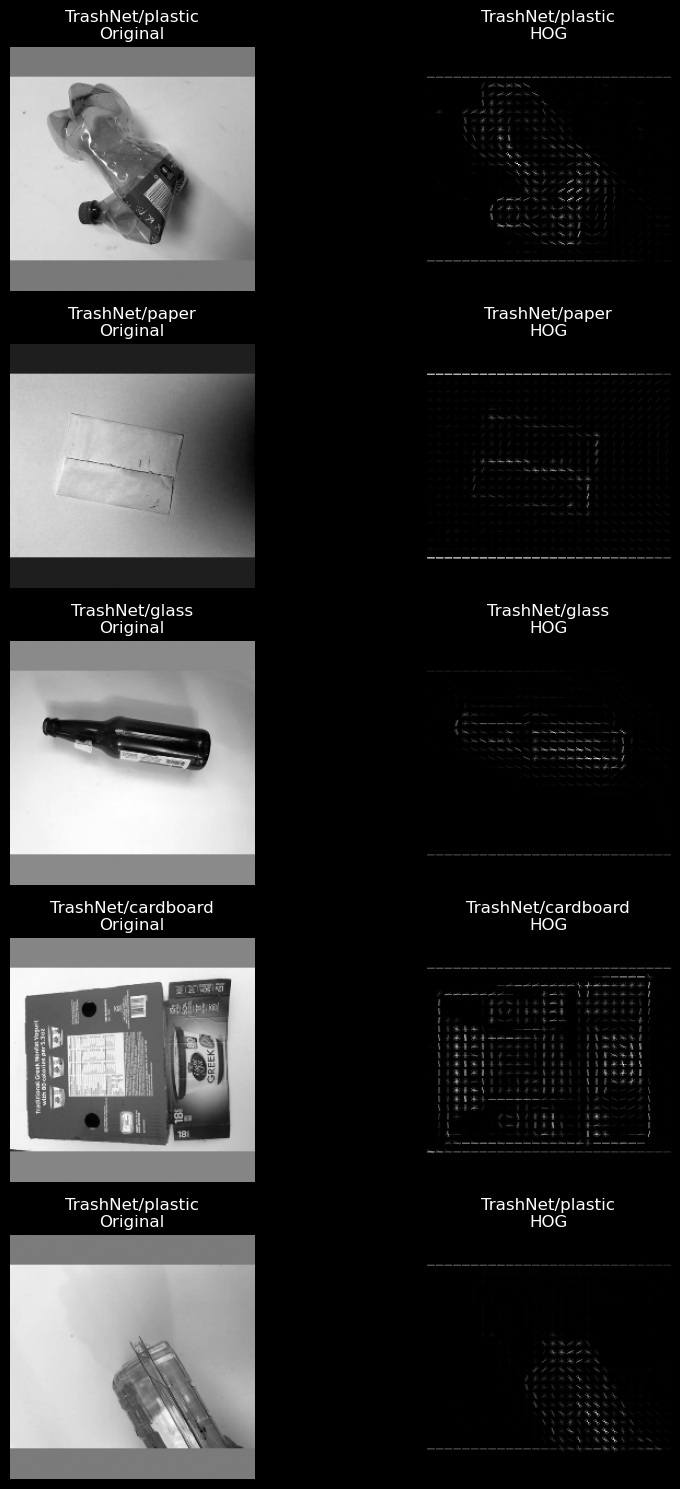

In [7]:
import random

# Mostrar 5 ejemplos aleatorios con su HOG correspondiente
datasets = sorted(os.listdir(data_dir))
print("Datasets detectados:", datasets)

fig, axes = plt.subplots(5, 2, figsize=(10, 15))  # 5 filas, 2 columnas: original y HOG

for i in range(5):
    dataset = random.choice(datasets)
    dataset_path = os.path.join(data_dir, dataset)
    
    # Buscar subclases dentro del dataset
    subclases = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    subclase = random.choice(subclases)
    sub_path = os.path.join(dataset_path, subclase)
    
    # Escoger una imagen aleatoria
    img_name = random.choice(os.listdir(sub_path))
    img_path = os.path.join(sub_path, img_name)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # Redimensionar si es pequeña
    if img.shape[0] < 64 or img.shape[1] < 64:
        img = cv2.resize(img, (128, 128))

    # Calcular HOG + visualización
    _, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Mostrar imagen original
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"{dataset}/{subclase}\nOriginal")
    axes[i, 0].axis('off')

    # Mostrar HOG
    axes[i, 1].imshow(hog_image, cmap='gray')
    axes[i, 1].set_title(f"{dataset}/{subclase}\nHOG")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()



Extrayendo características HOG para TrashNet...
Extracción completada en 81.07 segundos. Total imágenes: 2499
Entrenando modelo SVM para TrashNet...

=== REPORTE DE CLASIFICACIÓN (S0 - TrashNet) ===
              precision    recall  f1-score   support

   cardboard       0.65      0.74      0.69        80
       glass       0.49      0.55      0.52       100
       metal       0.49      0.52      0.51        82
       paper       0.79      0.67      0.72       115
     plastic       0.48      0.49      0.49        96
       trash       0.87      0.48      0.62        27

    accuracy                           0.59       500
   macro avg       0.63      0.58      0.59       500
weighted avg       0.60      0.59      0.59       500



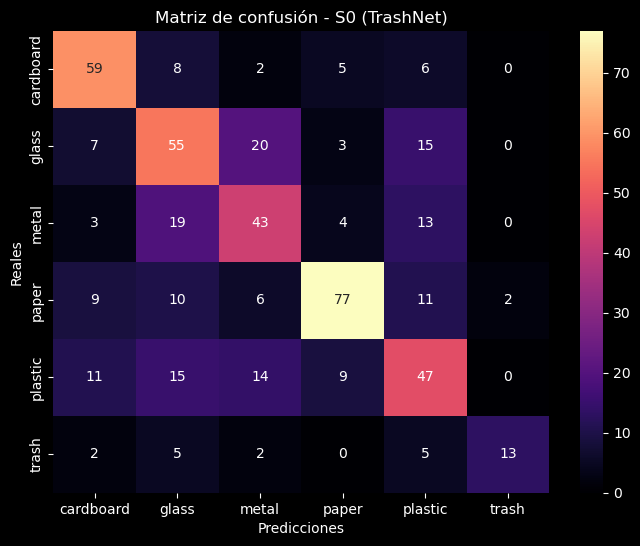

In [11]:
# ================================
# ESCENARIO S0 — TRASHNET
# ================================
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Ruta del dataset S0
data_dir = "../../data_preprocessed/HOG_SVM/TrashNet"

X, y = [], []
print("Extrayendo características HOG para TrashNet...")

inicio = time.time()

# Recorrer clases dentro de TrashNet
for clase in sorted(os.listdir(data_dir)):
    clase_path = os.path.join(data_dir, clase)
    if not os.path.isdir(clase_path):
        continue
    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
        X.append(features)
        y.append(clase)

fin = time.time()
print(f"Extracción completada en {fin - inicio:.2f} segundos. Total imágenes: {len(X)}")

# Entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Entrenando modelo SVM para TrashNet...")
svm_trash = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_trash.fit(X_train, y_train)

# Evaluación
y_pred = svm_trash.predict(X_test)
print("\n=== REPORTE DE CLASIFICACIÓN (S0 - TrashNet) ===")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión - S0 (TrashNet)")
plt.show()


Extrayendo características HOG para TACO...
Extracción completada en 132.20 segundos. Total imágenes: 4374
Entrenando modelo SVM para TACO...

=== REPORTE DE CLASIFICACIÓN (S1 - TACO) ===
              precision    recall  f1-score   support

   cardboard       0.16      0.15      0.15        46
       glass       0.20      0.18      0.19        49
       metal       0.33      0.38      0.35       103
       paper       0.03      0.02      0.02        44
     plastic       0.55      0.58      0.57       382
       trash       0.45      0.41      0.43       251

    accuracy                           0.44       875
   macro avg       0.29      0.29      0.29       875
weighted avg       0.43      0.44      0.43       875



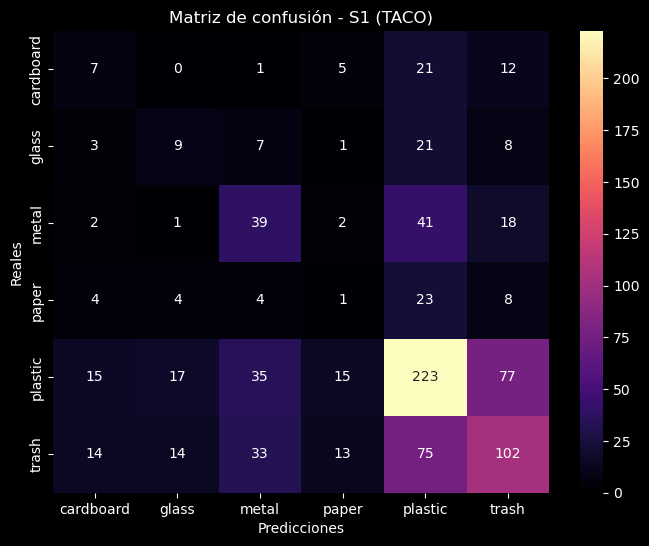

In [12]:
# ================================
# ESCENARIO S1 — TACO
# ================================
import os, time, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Ruta del dataset S1
data_dir = "../../data_preprocessed/HOG_SVM/TACO"

X, y = [], []
print("Extrayendo características HOG para TACO...")

inicio = time.time()

# Recorrer clases dentro de TACO
for clase in sorted(os.listdir(data_dir)):
    clase_path = os.path.join(data_dir, clase)
    if not os.path.isdir(clase_path):
        continue
    for img_name in os.listdir(clase_path):
        img_path = os.path.join(clase_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
        X.append(features)
        y.append(clase)

fin = time.time()
print(f"Extracción completada en {fin - inicio:.2f} segundos. Total imágenes: {len(X)}")

# Entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Entrenando modelo SVM para TACO...")
svm_taco = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_taco.fit(X_train, y_train)

# Evaluación
y_pred = svm_taco.predict(X_test)
print("\n=== REPORTE DE CLASIFICACIÓN (S1 - TACO) ===")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión - S1 (TACO)")
plt.show()


In [13]:
import joblib
os.makedirs("modelos_guardados", exist_ok=True)

joblib.dump(svm_trash, "modelos_guardados/hog_svm_trashnet.pkl")
print("✅ Modelo del escenario S0 (TrashNet) guardado exitosamente")


✅ Modelo del escenario S0 (TrashNet) guardado exitosamente


In [14]:
import joblib
os.makedirs("modelos_guardados", exist_ok=True)

joblib.dump(svm_taco, "modelos_guardados/hog_svm_taco.pkl")
print("✅ Modelo del escenario S1 (TACO) guardado exitosamente")


✅ Modelo del escenario S1 (TACO) guardado exitosamente
